# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://deep-learning-su.github.io/assignment-requirements/) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from deep_learning_su.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'deep_learning_su/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **deep_learning_su/classifiers/softmax.py**. 


In [173]:
# First implement the naive softmax loss function with nested loops.
# Open the file deep_learning_su/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from deep_learning_su.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.376641
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Понеже log loss-a работи с вероятности, то в началото е нормално да имаме еднаква вероятност за всеки от класовете т.е 1/10, т.е 0.1*


In [192]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from deep_learning_su.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.476270 analytic: 0.476270, relative error: 1.597390e-08
numerical: 0.129010 analytic: 0.129010, relative error: 1.837450e-07
numerical: -3.482872 analytic: -3.482872, relative error: 1.948218e-09
numerical: -0.151255 analytic: -0.151255, relative error: 2.424498e-07
numerical: -1.513477 analytic: -1.513477, relative error: 1.452999e-08
numerical: -1.263239 analytic: -1.263239, relative error: 1.514730e-08
numerical: -1.667911 analytic: -1.667911, relative error: 3.905909e-08
numerical: -0.743110 analytic: -0.743110, relative error: 2.007550e-08
numerical: 1.272117 analytic: 1.272117, relative error: 1.295974e-08
numerical: -1.196715 analytic: -1.196715, relative error: 1.547958e-08
numerical: 3.673391 analytic: 3.659645, relative error: 1.874579e-03
numerical: 2.810212 analytic: 2.807869, relative error: 4.170619e-04
numerical: 0.489228 analytic: 0.472061, relative error: 1.785851e-02
numerical: -1.488299 analytic: -1.483099, relative error: 1.750158e-03
numerical: 0.98442

In [200]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from deep_learning_su.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.376641e+00 computed in 0.107581s
[[-2.23503819e+00 -3.41799623e+00  1.31219316e+00 ... -5.12138783e-01
  -1.90685107e+00 -1.94477270e+00]
 [-3.87254853e+00 -3.34077454e+00  1.56563134e+00 ... -3.14610541e-01
  -2.74019590e+00 -3.05899189e+00]
 [-6.14569866e+00 -3.91234657e+00  3.29021322e+00 ...  2.07301778e-01
  -4.59301623e+00 -4.54775674e+00]
 ...
 [-1.00691251e+00  6.69003923e-02 -1.06964407e+00 ... -3.15770380e-01
  -3.20032392e-01 -1.62246744e-01]
 [-1.68601287e+00 -1.65598448e+00  5.75586899e-01 ...  1.39174256e+00
  -2.07222351e+00 -1.02961096e+00]
 [-6.88279317e-03  1.51027840e-02 -7.76964152e-03 ... -1.80932941e-03
   1.15775225e-02 -2.39570223e-03]]
vectorized loss: 2.376641e+00 computed in 0.008748s
Loss difference: 0.000000
Gradient difference: 0.000000


In [206]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from deep_learning_su.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 2.0e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
def score(y_pred, y):
    return np.mean(y_pred== y)

for rate in learning_rates:
    for c in regularization_strengths:
        model = Softmax()
        model.train(X_train, y_train, learning_rate=rate, reg=c,
                      num_iters=1500, verbose=True)
        train_score = score(model.predict(X_train),y_train)
        val_score = score(model.predict(X_val), y_val)
        if(best_val < val_score):
            best_val = val_score
            best_softmax = model
        results[(rate,c)] = (train_score, val_score)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 775.572029
iteration 100 / 1500: loss 284.526255
iteration 200 / 1500: loss 105.516173
iteration 300 / 1500: loss 39.940206
iteration 400 / 1500: loss 15.854437
iteration 500 / 1500: loss 7.145201
iteration 600 / 1500: loss 3.979766
iteration 700 / 1500: loss 2.752342
iteration 800 / 1500: loss 2.369586
iteration 900 / 1500: loss 2.131234
iteration 1000 / 1500: loss 2.126122
iteration 1100 / 1500: loss 2.054341
iteration 1200 / 1500: loss 2.038133
iteration 1300 / 1500: loss 2.086052
iteration 1400 / 1500: loss 2.115529
iteration 0 / 1500: loss 620.807228
iteration 100 / 1500: loss 278.235511
iteration 200 / 1500: loss 125.550442
iteration 300 / 1500: loss 57.236753
iteration 400 / 1500: loss 26.785632
iteration 500 / 1500: loss 13.188828
iteration 600 / 1500: loss 7.030322
iteration 700 / 1500: loss 4.318744
iteration 800 / 1500: loss 3.086557
iteration 900 / 1500: loss 2.524021
iteration 1000 / 1500: loss 2.229835
iteration 1100 / 1500: loss 2.140333
iteratio

In [207]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.359000


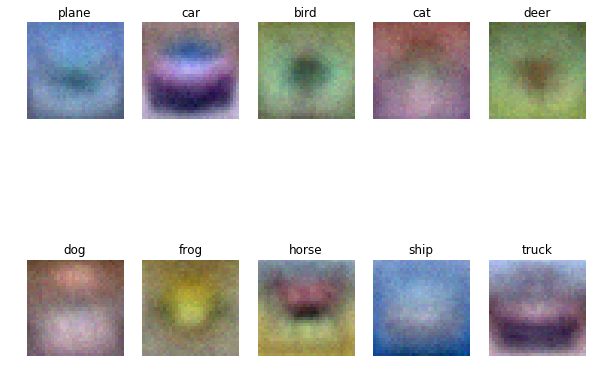

In [208]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])